## Librerías:

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from torchvision.models import resnet50, resnet101, resnet152, ResNet50_Weights,ResNet101_Weights, ResNet152_Weights
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Visualizar una matriz de confusión para una etiqueta específica
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from SupportFunc.Loader import MultiLabelImageDataset
from SupportFunc.AdaptiveAttention import AdaptiveAttention, AdaptiveTransformerEncoderLayer
from SupportFunc.Visualization import plot_confusion_matrix, plot_train_val_curve

## Parámetros y funciones:

In [3]:
class AdaptiveAttentionClassifier(nn.Module):
    def __init__(self, image_feature_dim, num_classes):
        super(AdaptiveAttentionClassifier, self).__init__()
        self.image_embed = nn.Linear(image_feature_dim, 512)
        self.transformer_encoder = nn.ModuleList([
            AdaptiveTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(6)
        ])
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, image_features):
        # Proyección de características
        image_embeddings = self.image_embed(image_features)

        # Pasar por las capas del Transformer
        for layer in self.transformer_encoder:
            image_embeddings = layer(image_embeddings.unsqueeze(1)).squeeze(1)

        # Clasificador final
        output = self.mlp(image_embeddings)
        return output


In [4]:
# Obtener el directorio actual
current_directory = os.getcwd()
data_directory = os.path.join(current_directory[:-3], 'data')
images_directory = os.path.join(data_directory, 'images')

num_epochs = 1
batch_size = 32
lr = 0.0001
image_feature_dim = 2048

subset = [os.path.splitext(filename)[0] for filename in os.listdir(images_directory)]
print(len(subset))

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

2451


## Carga de datos:

### Selección de subset para pruebas:

In [5]:
# Leer y filtrar datos
train_1 = pd.read_csv(f'{data_directory}/train_data.csv')
test_1 = pd.read_csv(f'{data_directory}/test_data.csv')

train_1 = train_1[train_1['ID'].isin(subset[:500])]
test_1 = test_1[test_1['ID'].isin(subset[:500])]

# Guardar los archivos filtrados
train_1.to_csv(f'{data_directory}/train_data_2.csv', encoding = 'utf-8', index=False)
train_1.to_csv(f'{data_directory}/test_data_2.csv', encoding = 'utf-8', index=False)

# Crear datasets y DataLoaders
train_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/train_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
test_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/test_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Instanciar modelo:

In [6]:
# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet = models.resnet101(weights=ResNet101_Weights.DEFAULT)  # Para ResNet101
#resnet = models.resnet152(weights=ResNet152_Weights.DEFAULT)  # Para ResNet152

# Congelar todas las capas inicialmente
for param in resnet.parameters():
    param.requires_grad = False

# Descongelar las capas que quieres ajustar (por ejemplo, 'layer4' o 'fc')
for param in resnet.layer4.parameters():  # Afinar el bloque final
    param.requires_grad = True
    
# Reemplazar la capa final con una capa adaptada a tu número de clases
num_classes = train_dataset[0][1].size(0)  # Obtener el número de clases desde el dataset
resnet.fc = nn.Identity()
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

model = AdaptiveAttentionClassifier(image_feature_dim=image_feature_dim, num_classes=num_classes)
model = model.to(device)

# Optimizador y función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=lr)

In [7]:
#Comprobar que las dimensiones de salida de resnet sean consistentes con la siguiente capa
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
image_features = resnet(images)
print(image_features.shape)

torch.Size([32, 2048])


## Entrenamiento:

In [ ]:
# Listas para almacenar pérdidas y métricas
train_losses = list()
val_losses = list()
train_accuracies = list()
val_accuracies = list()
train_f1_scores = list()
val_f1_scores = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calcular predicciones para métricas
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()  # Umbral de 0.5 para predicciones binarias
        all_train_labels.append(labels.cpu().numpy())
        all_train_preds.append(preds.cpu().numpy())

    # Calcular métricas para entrenamiento
    all_train_labels = np.vstack(all_train_labels)
    all_train_preds = np.vstack(all_train_preds)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro", zero_division=1)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validación
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            image_features = resnet(images).flatten(start_dim=1)
            outputs = model(image_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calcular predicciones para métricas
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()  # Umbral de 0.5 para predicciones binarias
            all_val_labels.append(labels.cpu().numpy())
            all_val_preds.append(preds.cpu().numpy())

    # Calcular métricas para validación
    all_val_labels = np.vstack(all_val_labels)
    all_val_preds = np.vstack(all_val_preds)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average="macro", zero_division=1)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    # Imprimir métricas
    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
        f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, "
        f"Train F1: {train_f1_scores[-1]:.4f}, Val F1: {val_f1_scores[-1]:.4f}"
    )

c:\Users\jomunozf\Documents\GitHub\Transformer_AdapAttention\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1, Train Loss: 0.5762, Val Loss: 0.5192, Train Acc: 0.0214, Val Acc: 0.0402, Train F1: 0.0657, Val F1: 0.0258


c:\Users\jomunozf\Documents\GitHub\Transformer_AdapAttention\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


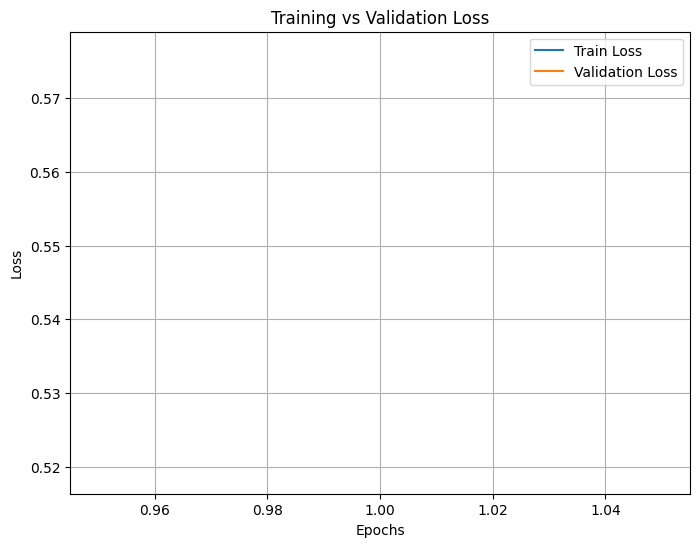

In [10]:
plot_train_val_curve(num_epochs, train_losses, val_losses)

## Inferencia y métricas:

In [10]:
# Coloca el modelo en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predicciones
all_labels = list()
all_preds = list()

# Realizar inferencia
with torch.no_grad():  # No calculamos gradientes
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Extraer características con ResNet y pasar por el modelo
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)

        # Aplicar sigmoid para obtener probabilidades
        probs = torch.sigmoid(outputs)

        # Convertir probabilidades en predicciones binarias (umbral = 0.5)
        preds = (probs > 0.5).int()

        # Guardar etiquetas reales y predicciones
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Convertir listas a arreglos
all_labels = np.vstack(all_labels)  # Etiquetas reales
all_preds = np.vstack(all_preds)    # Predicciones

# Calcular matriz de confusión para cada etiqueta
confusion_matrices = multilabel_confusion_matrix(all_labels, all_preds)

In [14]:
# Imprimir métricas de clasificación
print("Reporte de clasificación (por etiqueta):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.data.columns[1:], zero_division=0))

Reporte de clasificación (por etiqueta):
              precision    recall  f1-score   support

          DR       0.52      0.49      0.50        65
      NORMAL       0.00      0.00      0.00        33
          MH       0.14      0.41      0.21        27
         ODC       0.25      0.20      0.22        25
        TSLN       0.00      0.00      0.00        23
        ARMD       0.05      0.91      0.09        11
          DN       0.08      0.04      0.05        25
         MYA       0.09      0.71      0.16        14
        BRVO       0.09      0.50      0.16        12
         ODP       0.06      0.40      0.11         5
        CRVO       0.00      0.00      0.00         2
         CNV       0.00      0.00      0.00         0
          RS       0.02      0.25      0.03         4
         ODE       0.02      1.00      0.05         4
          LS       0.04      0.10      0.06        10
         CSR       0.07      0.60      0.12         5
         HTR       0.00      0.00      0

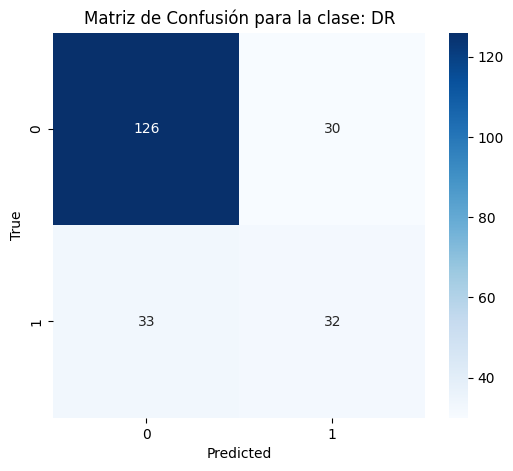

In [15]:
# Ejemplo: Visualizar la matriz de confusión para la primera etiqueta
class_name = test_dataset.data.columns[1]
plot_confusion_matrix(confusion_matrices[0], class_name)

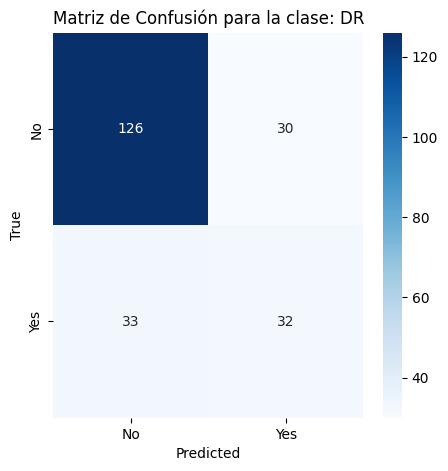

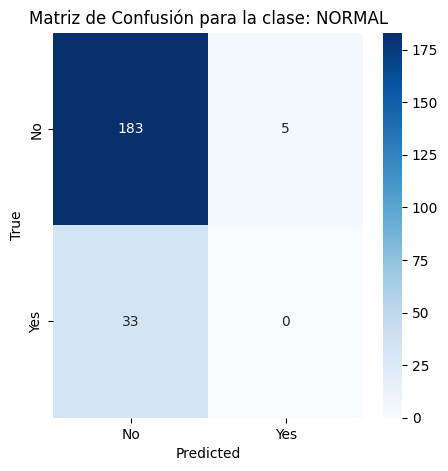

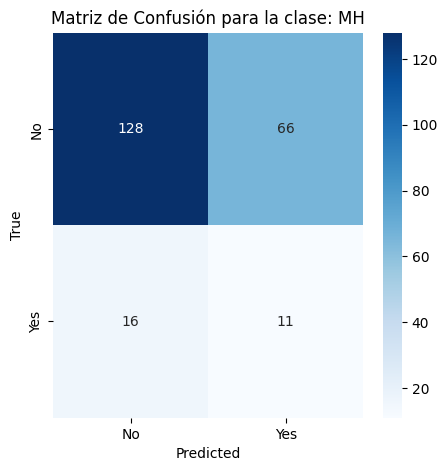

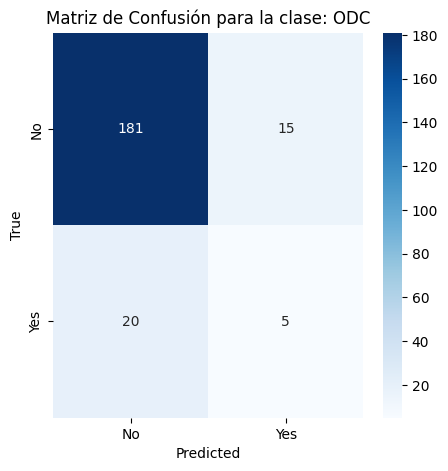

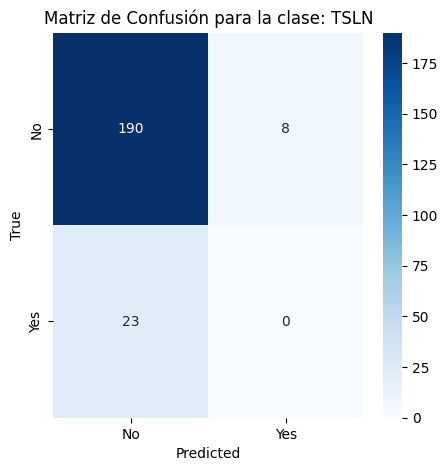

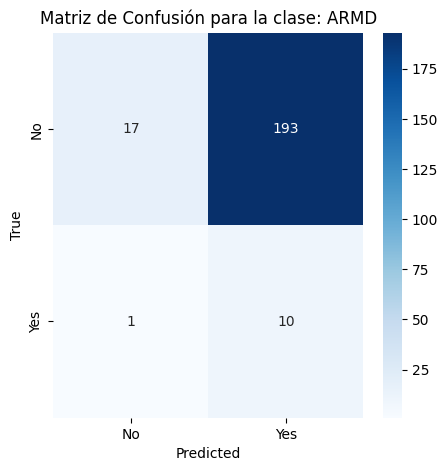

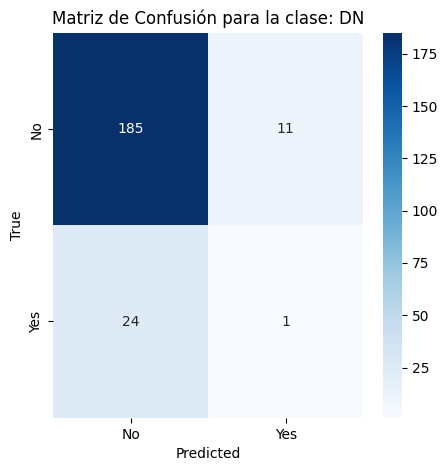

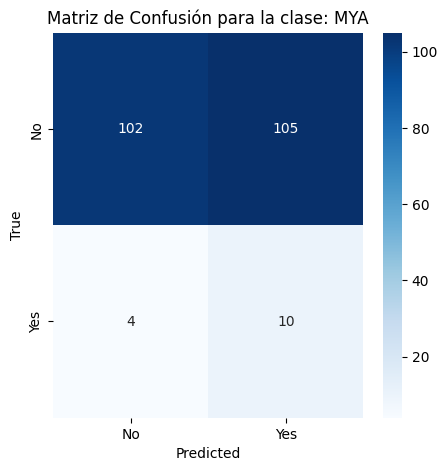

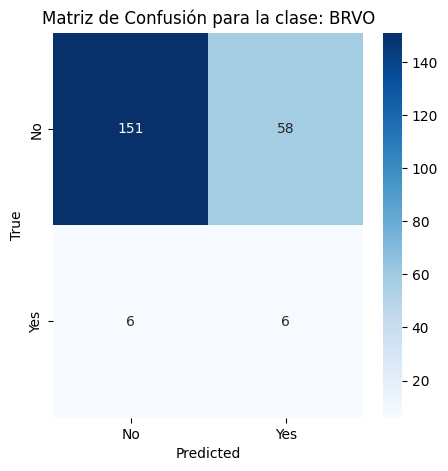

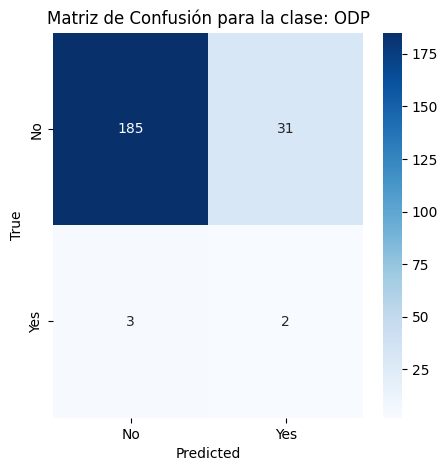

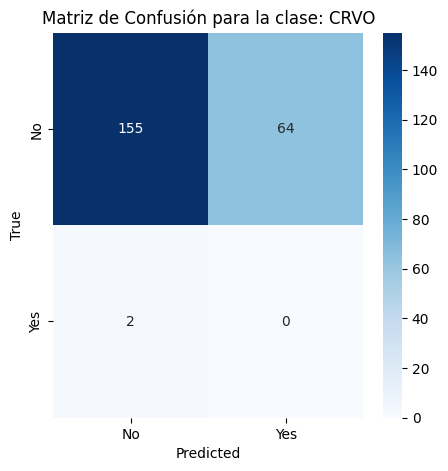

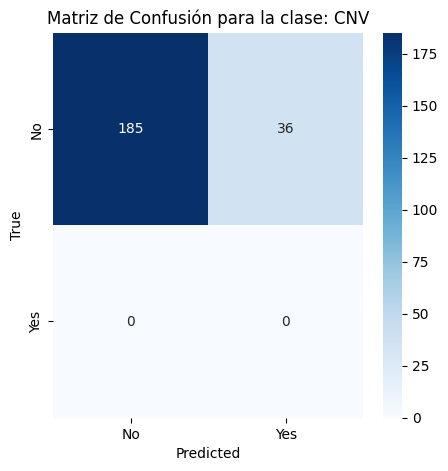

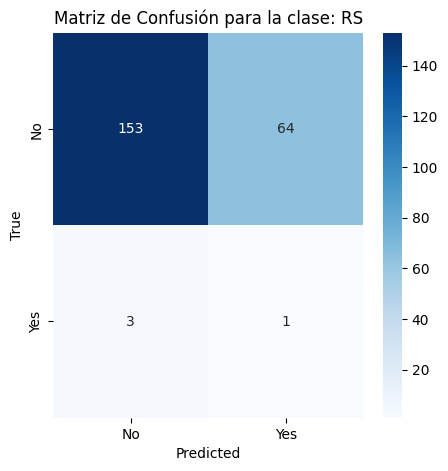

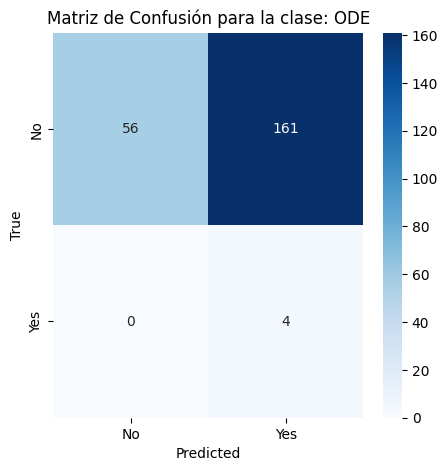

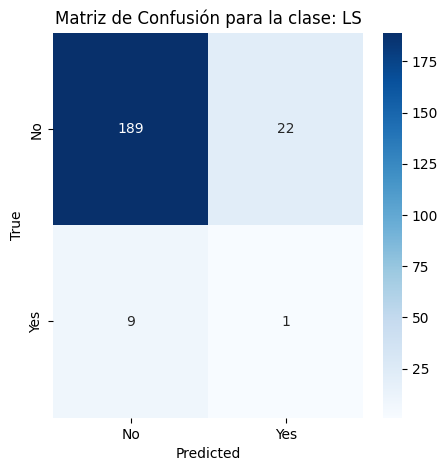

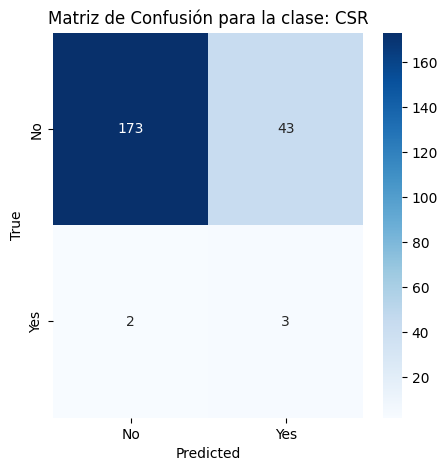

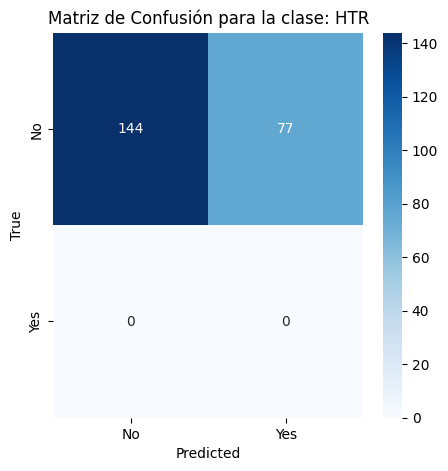

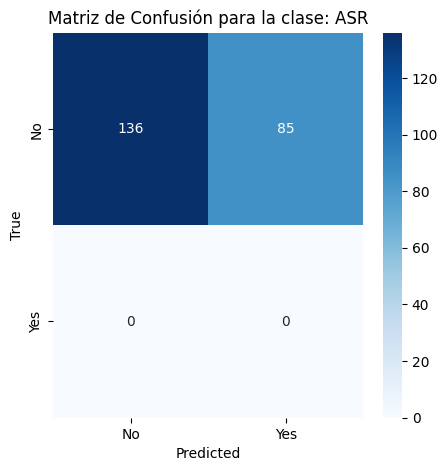

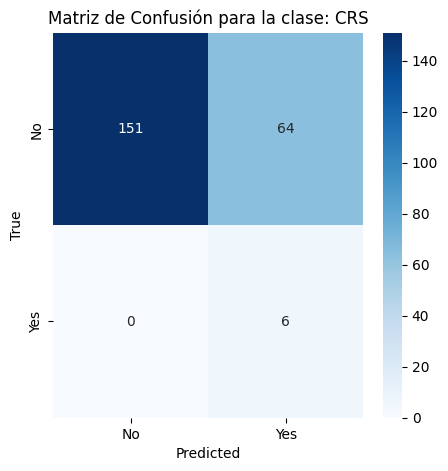

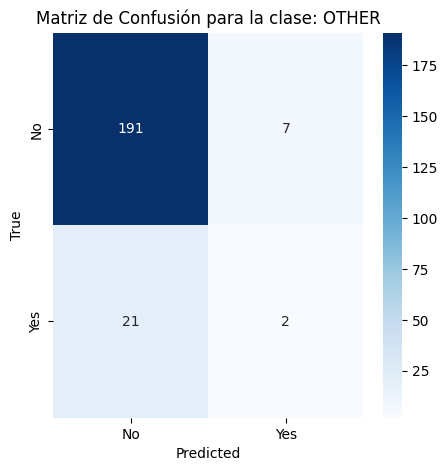

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar todas las matrices de confusión
for idx, cm in enumerate(confusion_matrices):
    class_name = test_dataset.data.columns[idx + 1]  # Ajustar el índice según las columnas del dataset
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Matriz de Confusión para la clase: {class_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


---